# transversity2

In [1]:
import sys,os
os.chdir('../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text',usetex=True)
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from resman import RESMAN
import nest

## setup

In [2]:
path='outputs/transversity4'

In [3]:
conf=load_config('%s/transversity4.py'%path)
resman=RESMAN(conf);
parman=resman.conf['parman']
#nest=nest.load('%s/nest'%path)
nest=load('%s/nest'%path)
nest.keys()

loading sidis data sets 4000
loading sidis data sets 4001
loading sidis data sets 4002
loading sidis data sets 4003
loading sidis data sets 4004
loading sidis data sets 4005
loading sidis data sets 4006
loading sidis data sets 4007
loading sidis data sets 4008
loading sidis data sets 4009
loading sidis data sets 4010
loading sidis data sets 4011
loading sidis data sets 3000
loading sidis data sets 3003
loading sidis data sets 3004
loading sidis data sets 3005
loading sidis data sets 3007
loading sidis data sets 3008
loading sidis data sets 3010
loading sidis data sets 3012
loading sidis data sets 3013
loading sidis data sets 3016
loading sidis data sets 3017
loading sidis data sets 3018
loading sidis data sets 3021
loading sidis data sets 3023
loading sidis data sets 3024
loading sidis data sets 3025
loading sidis data sets 3026
loading sidis data sets 3027
loading moments data sets 1000


['x', 'logz', 'l', 'samples', 'weights']

## analyze nested sampling statistics

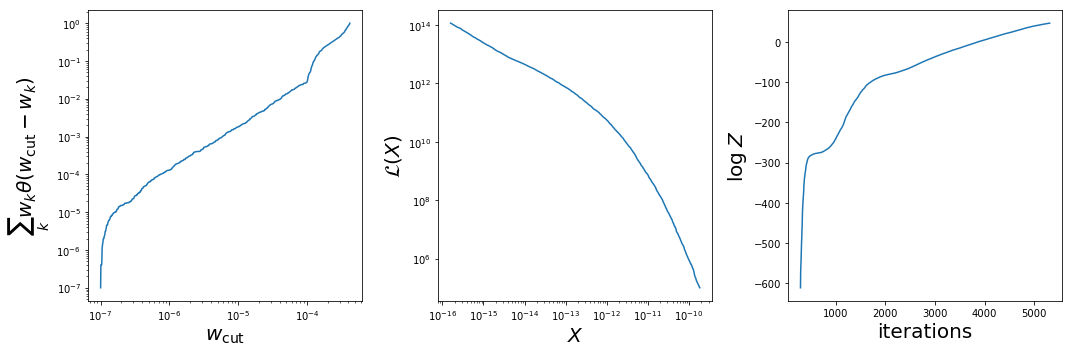

In [4]:
wmin_cut=1e-7
nrows,ncols=1,3
py.figure(figsize=(ncols*5,nrows*5))

ax=py.subplot(nrows,ncols,1)
weights=np.copy(nest['weights'])
weights=[w for w in weights if w>wmin_cut]
wmin=np.amin(weights)
wmax=np.amax(weights)
w=10**np.linspace(np.log10(wmin),np.log10(wmax),1000)
wsum=lambda wcut: np.sum([w for w in weights if w<wcut])
ax.plot(w,[wsum(wcut) for wcut in w])
ax.semilogx();
ax.semilogy();
ax.set_ylabel(r'$\sum_k w_k \theta(w_{\rm cut}-w_k)$',size=20)
ax.set_xlabel(r'$w_{\rm cut}$',size=20)

ax=py.subplot(nrows,ncols,2)
X=[nest['x'][i] for i in range(len(nest['x'])) if nest['weights'][i]>wmin_cut]
L=[nest['l'][i] for i in range(len(nest['l'])) if nest['weights'][i]>wmin_cut]
ax.plot(X,L)
ax.semilogx()
ax.semilogy()
ax.set_ylabel(r'${\cal L}(X)$',size=20)
ax.set_xlabel(r'$X$',size=20)

ax=py.subplot(nrows,ncols,3)
it=[i for i in range(len(nest['x'])) if nest['weights'][i]>wmin_cut]
LOGZ=[nest['logz'][i] for i in range(len(nest['l'])) if nest['weights'][i]>wmin_cut]
ax.plot(it,LOGZ)
ax.set_ylabel(r'$\log \;Z$',size=20)
ax.set_xlabel(r'iterations',size=20)

py.tight_layout()

## remove samples using sum_w cut criterion.  

In [5]:
weights=[nest['weights'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
samples=[nest['samples'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
weights/=np.sum(weights)
fnest={}
fnest['weights']=weights
fnest['samples']=samples
print 'nes=%d  fnest=%d'%(len(nest['samples']),len(fnest['samples']))

nes=13844  fnest=5313


## data vs theory

In [6]:
# time consuming: run if is necessary

def get_RAW():
    RAW={}
    for k in conf['datasets']: 
        RAW[k]={}
        for kk in conf['datasets'][k]['xlsx']: 
            RAW[k][kk]=[]
    return RAW
        
samples=fnest['samples']
weights=fnest['weights']

THY=get_RAW()
RES=get_RAW()
bar=BAR('gen chi2 values',len(samples))
for i in range(len(samples)):
    par=samples[i]
    resman.get_residuals(par)
    for k in RES:
        if k=='sidis': 
            for kk in RES[k]: 
                THY[k][kk].append(np.copy(resman.sidisres.tabs[kk]['thy']))
                RES[k][kk].append(np.copy(resman.sidisres.tabs[kk]['residuals']))
        if k=='moments': 
            for kk in RES[k]:
                THY[k][kk].append(np.copy(resman.momres.tabs[kk]['thy']))
                RES[k][kk].append(np.copy(resman.momres.tabs[kk]['residuals']))
    bar.next()
bar.finish()
RAW={'THY':THY,'RES':RES}
save(RAW,'%s/raw'%path)

gen chi2 values [100%]


In [24]:
RAW=load('%s/raw'%path)

In [31]:
RES=RAW['RES']
THY=RAW['THY']

for k in RES:
    for kk in RES[k]: 
        if k=='sidis': 
            thy =np.einsum('k,ki',weights,np.array(THY[k][kk]))
            dthy=np.einsum('k,ki',weights,(np.array(THY[k][kk])-thy)**2)**0.5
            residuals=np.einsum('k,ki',weights,RES[k][kk])
            resman.sidisres.tabs[kk]['thy']=thy
            resman.sidisres.tabs[kk]['dthy']=dthy
            resman.sidisres.tabs[kk]['residuals']=residuals
            resman.sidisres.tabs[kk]['chi2']=residuals**2
            resman.sidisres.tabs[kk]=pd.DataFrame(resman.sidisres.tabs[kk])

## AUT plot

In [32]:
def plot_AUT(K):
    ncols=4
    nrows=len(K)/ncols
    if len(K)%ncols!=0: nrows+=1
    py.figure(figsize=(ncols*4,nrows*2))
    cnt=0
    CHI2=0
    NPTS=0
    for k in K:
        cnt+=1
        d=resman.sidisres.tabs[k]
        chi2=np.sum(d.residuals**2)
        npts=d.residuals.size
        CHI2+=chi2
        NPTS+=npts
        ax=py.subplot(nrows,ncols,cnt)
        dep=d['dependence'].values[0]
        obs=d['obs'].values[0]
        tar=d['target'].values[0]
        had=d['hadron'].values[0]
        if dep=='pt': dep='pT'
        ax.errorbar(d[dep],d['value'],d['alpha'],fmt='k.')
        ax.fill_between(d[dep],d['thy']-d['dthy'],d['thy']+d['dthy'],alpha=0.5)
        ax.plot(d[dep],d['thy'])
        ax.set_xlabel(dep)
        ax.set_ylabel(obs)
        ax.set_title('%s %s chi2=%0.2f  npts=%d'%(tar,had,chi2,npts))
        py.tight_layout()
    print 'CHI2=%0.2f  NPTS=%d'%(CHI2,NPTS)
tabs=resman.sidisres.tabs
K=tabs.keys()

CHI2=58.40  NPTS=60


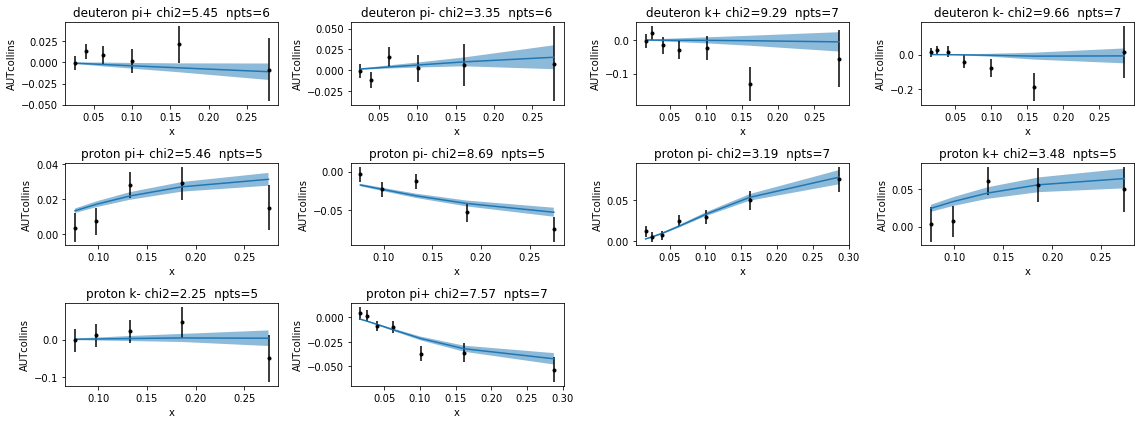

In [33]:
plot_AUT([k for k in K if k>=2000 if tabs[k]['dependence'].values[0]=='x'])

CHI2=47.95  NPTS=60


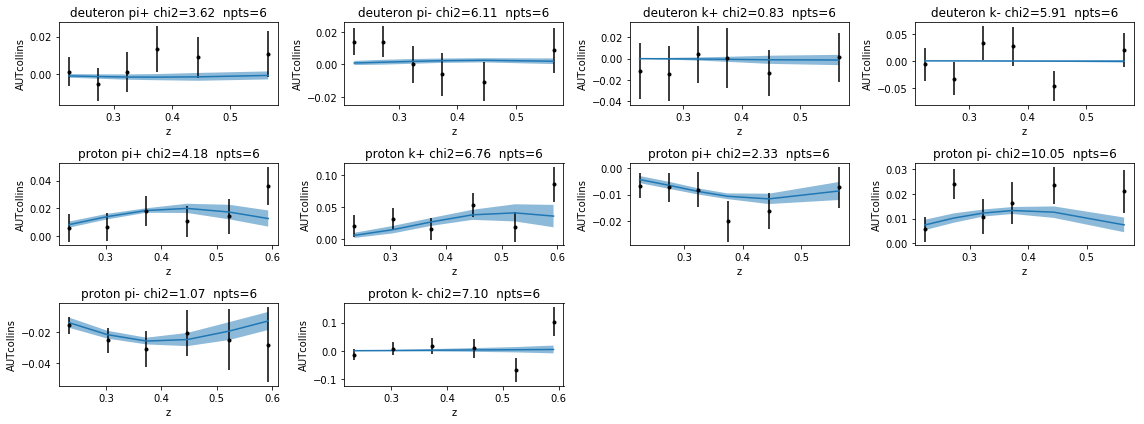

In [34]:
plot_AUT([k for k in K if k>=2000 if resman.sidisres.tabs[k]['dependence'].values[0]=='z'])

CHI2=16.28  NPTS=32


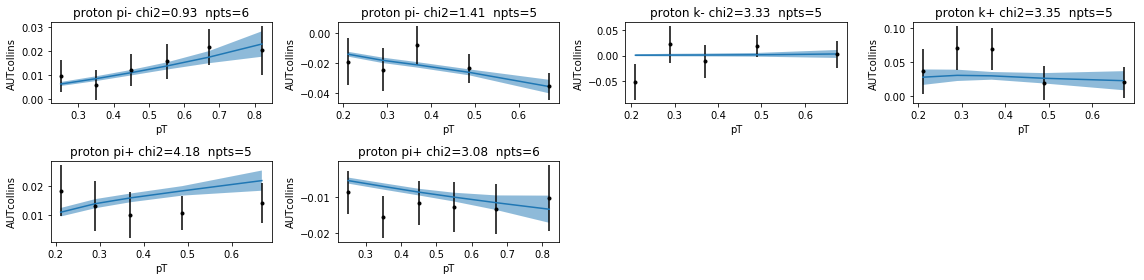

In [35]:
plot_AUT([k for k in K if k>=2000 if resman.sidisres.tabs[k]['dependence'].values[0]=='pt'])

## parameters

In [36]:
def plot_params(k,kk):
    order=parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==k if order[i][2]==_kk][0]
    nrows,ncols=1,5
    py.figure(figsize=(ncols*3,nrows*2))
    for i in range(len(kk)):
        ax=py.subplot(nrows,ncols,i+1)
        par=np.transpose(samples)[get_idx(kk[i])]
        mean=np.einsum('k,k',weights,par) 
        std=np.einsum('k,k',weights,(np.array(par)-mean)**2)**0.5 
        ax.hist(par,histtype='stepfilled',weights=weights,bins=10,facecolor='Yellow',edgecolor='k')
        pmin=conf['params'][k][kk[i]]['min']
        pmax=conf['params'][k][kk[i]]['max']
        ax.set_xlim(pmin,pmax)
        #par=samples[get_idx(kk[i])]
        #ax.hist(par,histtype='stepfilled',weights=nes['weights'],range=(pmin,pmax),bins=10,facecolor='Yellow',edgecolor='k')        ax.hist(par1,histtype='stepfilled',weights=core1.nes['weights'],range=(pmin,pmax),bins=10,facecolor='none',edgecolor='r',hatch='...')
        ax.set_title('%s-%s'%(k,kk[i]))
        #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    py.tight_layout()


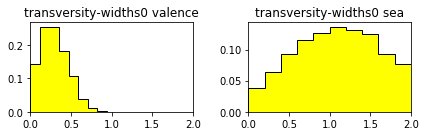

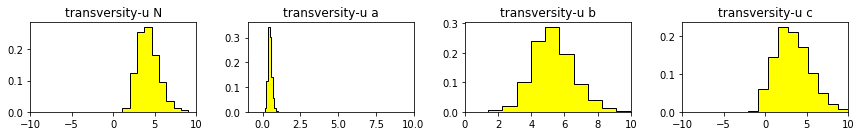

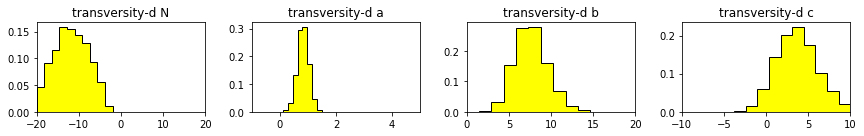

In [37]:
plot_params('transversity',['widths0 valence','widths0 sea'])
plot_params('transversity',['u N','u a','u b','u c'])
plot_params('transversity',['d N','d a','d b','d c'])

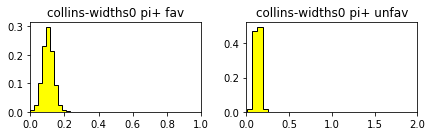

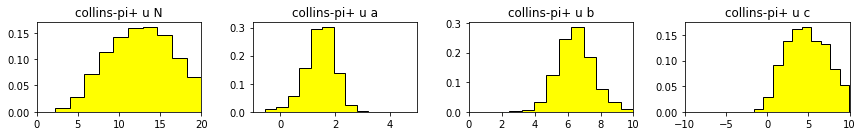

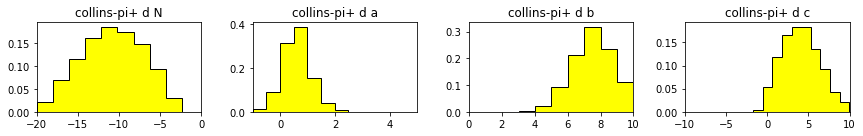

In [38]:
plot_params('collins',['widths0 pi+ fav','widths0 pi+ unfav'])
plot_params('collins',['pi+ u N','pi+ u a','pi+ u b','pi+ u c'])
plot_params('collins',['pi+ d N','pi+ d a','pi+ d b','pi+ d c'])

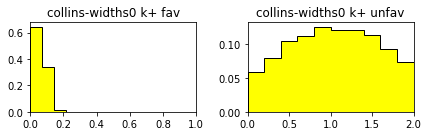

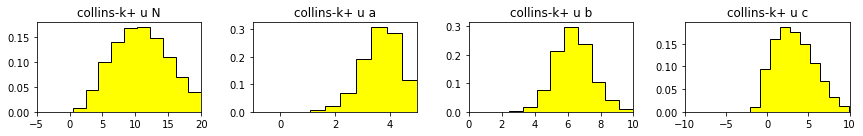

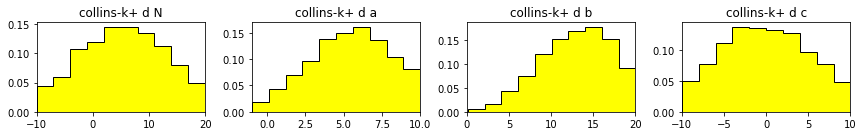

In [39]:
plot_params('collins',['widths0 k+ fav','widths0 k+ unfav'])
plot_params('collins',['k+ u N','k+ u a','k+ u b','k+ u c'])
plot_params('collins',['k+ d N','k+ d a','k+ d b','k+ d c'])

## PDFs and FFs

In [40]:
def calc(func,msg):
    RAW=[]
    bar=BAR(msg,len(samples))
    for i in range(len(samples)):
        par=samples[i]
        parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    f =np.einsum('k,kif->if',weights,RAW)
    df=np.einsum('k,kif->if',weights,(RAW-f)**2)**0.5
    f=np.einsum('if->fi',f)
    df=np.einsum('if->fi',df)
    return {'f':f,'df':df}

## Transversity

In [41]:
X1=10**np.linspace(-3,-1)
X2=np.linspace(0.101,0.999)
X=np.append(X1,X2)
h=calc(lambda : [resman.conf['transversity'].get_C(x,1) for x in X],'calc h')

calc h [100%]


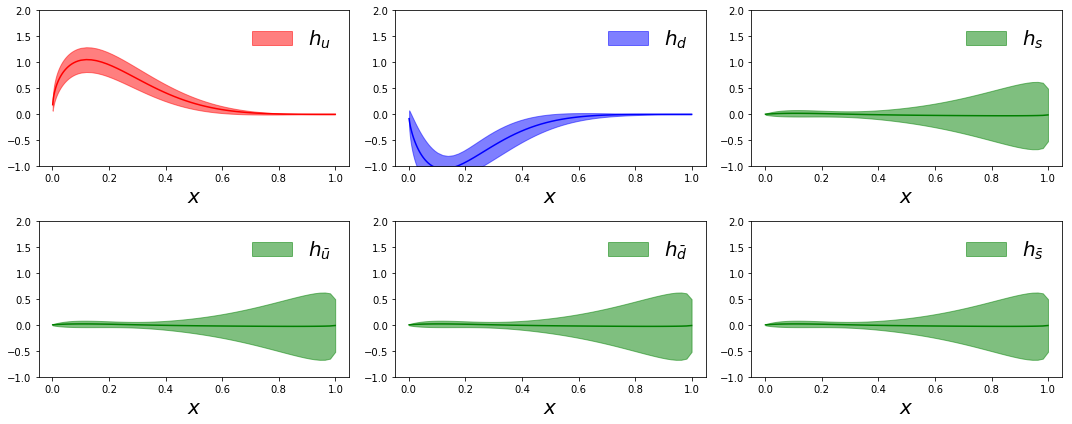

In [42]:
nrows,ncols=2,3
py.figure(figsize=(ncols*5,nrows*3))
def plot(idx,flav):
    ax=py.subplot(nrows,ncols,idx)
    # labels
    if flav==1: label=r'$h_u$'
    if flav==2: label=r'$h_{\bar{u}}$'
    if flav==3: label=r'$h_d$'
    if flav==4: label=r'$h_{\bar{d}}$'
    if flav==5: label=r'$h_{s}$'
    if flav==6: label=r'$h_{\bar{s}}$'
    # colors
    if flav==1: color='r'
    elif flav==3: color='b'
    elif any([flav==x for x in [2,4,5,6]]): color='g'
    # plots
    ax.fill_between(X,(h['f'][flav]-h['df'][flav]),(h['f'][flav]+h['df'][flav]),color=color,alpha=0.5,label=label)
    ax.plot(X,h['f'][flav],color=color)
    ax.set_xlabel(r'$x$',size=20)
    ax.set_ylim(-1,2)
    ax.legend(fontsize=20,frameon=False)
    return ax
    
ax=plot(1,1)
ax=plot(2,3)
ax=plot(3,5)
ax=plot(4,2)
ax=plot(5,4)
ax=plot(6,6)
py.tight_layout()

## Collins

In [43]:
Z1=10**np.linspace(-3,-1)
Z2=np.linspace(0.101,0.999)
Z=np.append(Z1,Z2)
Hpi=calc(lambda : [resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')

calc H(pi+) [100%]


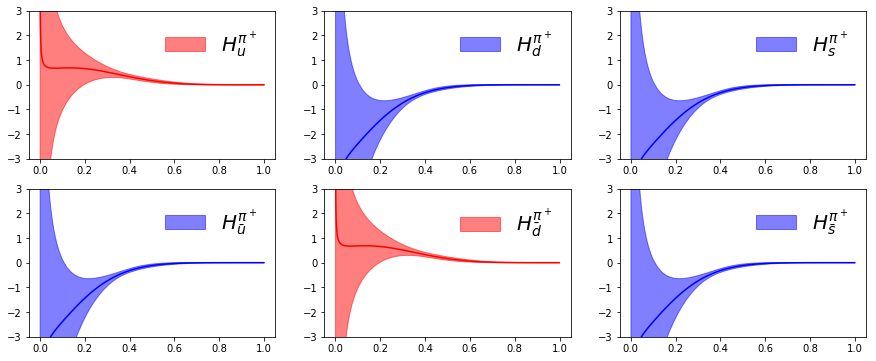

In [44]:
nrows,ncols=2,3
py.figure(figsize=(ncols*5,nrows*3))
def plot(idx,flav):
    ax=py.subplot(nrows,ncols,idx)
    # labels
    if flav==1: label=r'$H^{\pi^+}_u$'
    if flav==2: label=r'$H^{\pi^+}_{\bar{u}}$'
    if flav==3: label=r'$H^{\pi^+}_d$'
    if flav==4: label=r'$H^{\pi^+}_{\bar{d}}$'
    if flav==5: label=r'$H^{\pi^+}_{s}$'
    if flav==6: label=r'$H^{\pi^+}_{\bar{s}}$'
    # colors
    if flav==1 or flav==4: color='r'
    else: color='b'
    ax.fill_between(Z,(Hpi['f'][flav]-Hpi['df'][flav]),(Hpi['f'][flav]+Hpi['df'][flav]),color=color,alpha=0.5,label=label)
    ax.plot(Z,Hpi['f'][flav],color=color)
    ax.legend(fontsize=20,frameon=False)
    ax.set_ylim(-3,3)
    return ax
    
ax=plot(1,1)
ax=plot(2,3)
ax=plot(3,5)
ax=plot(4,2)
ax=plot(5,4)
ax=plot(6,6)

In [45]:
Z1=10**np.linspace(-3,-1)
Z2=np.linspace(0.101,0.999)
Z=np.append(Z1,Z2)
Hk=calc(lambda : [resman.conf['collins'].get_C(z,1,'k+') for z in Z],'calc H(k+)')

calc H(k+) [100%]


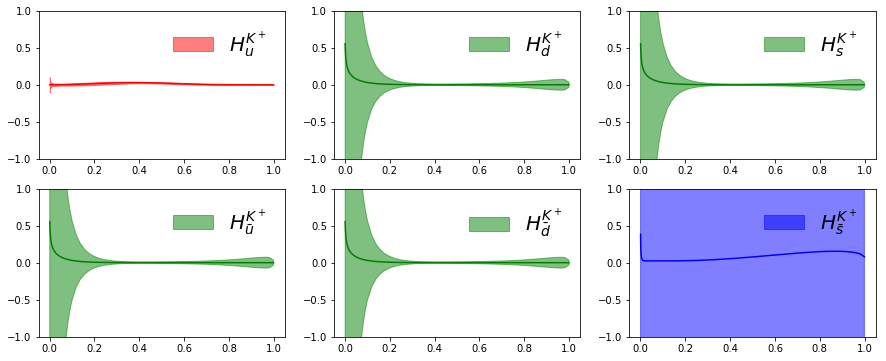

In [46]:
nrows,ncols=2,3
py.figure(figsize=(ncols*5,nrows*3))
def plot(idx,flav):
    ax=py.subplot(nrows,ncols,idx)
    # labels
    if flav==1: label=r'$H^{K^+}_u$'
    if flav==2: label=r'$H^{K^+}_{\bar{u}}$'
    if flav==3: label=r'$H^{K^+}_d$'
    if flav==4: label=r'$H^{K^+}_{\bar{d}}$'
    if flav==5: label=r'$H^{K^+}_{s}$'
    if flav==6: label=r'$H^{K^+}_{\bar{s}}$'
    # colors
    if flav==1: color='r'
    elif flav==6: color='b'
    else: color='g'
    ax.fill_between(Z,(Hk['f'][flav]-Hk['df'][flav]),(Hk['f'][flav]+Hk['df'][flav]),color=color,alpha=0.5,label=label)
    ax.plot(Z,Hk['f'][flav],color=color)
    ax.set_ylim(-1,1)
    ax.legend(fontsize=20,frameon=False)
    return ax
    
ax=plot(1,1)
ax=plot(2,3)
ax=plot(3,5)
ax=plot(4,2)
ax=plot(5,4)
ax=plot(6,6)